In [11]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import h5py

## Task 1: CNNs for Galaxy Classification

In [12]:
# create data folder if it does not exist
import os
os.makedirs("data", exist_ok=True)

import urllib.request
_, msg = urllib.request.urlretrieve(
    "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", 
    "data/Galaxy10.h5"
)

In [13]:
label_names = [
    'Disk, Face-on, No Spiral',
    'Smooth, Completely round',
    'Smooth, in-between round',
    'Smooth, Cigar shaped',
    'Disk, Edge-on, Rounded Bulge',
    'Disk, Edge-on, Boxy Bulge',
    'Disk, Edge-on, No Bulge',
    'Disk, Face-on, Tight Spiral',
    'Disk, Face-on, Medium Spiral',
    'Disk, Face-on, Loose Spiral'
]
n_classes = len(label_names)

# To get the images and labels from file
with h5py.File('data/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
images = images.astype(np.float32)

# comply to (batch, channel, height, width) convention of pytorch
images = np.moveaxis(images, -1, 1)  
# convert to torch
images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

print(f'{images.shape=}, {labels.shape=}')

images.shape=torch.Size([21785, 3, 69, 69]), labels.shape=torch.Size([21785])


### (a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..206.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..221.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..180.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..234.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.0..230.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..253.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..236.0].
Clipping input data to the valid range for imshow with RGB dat

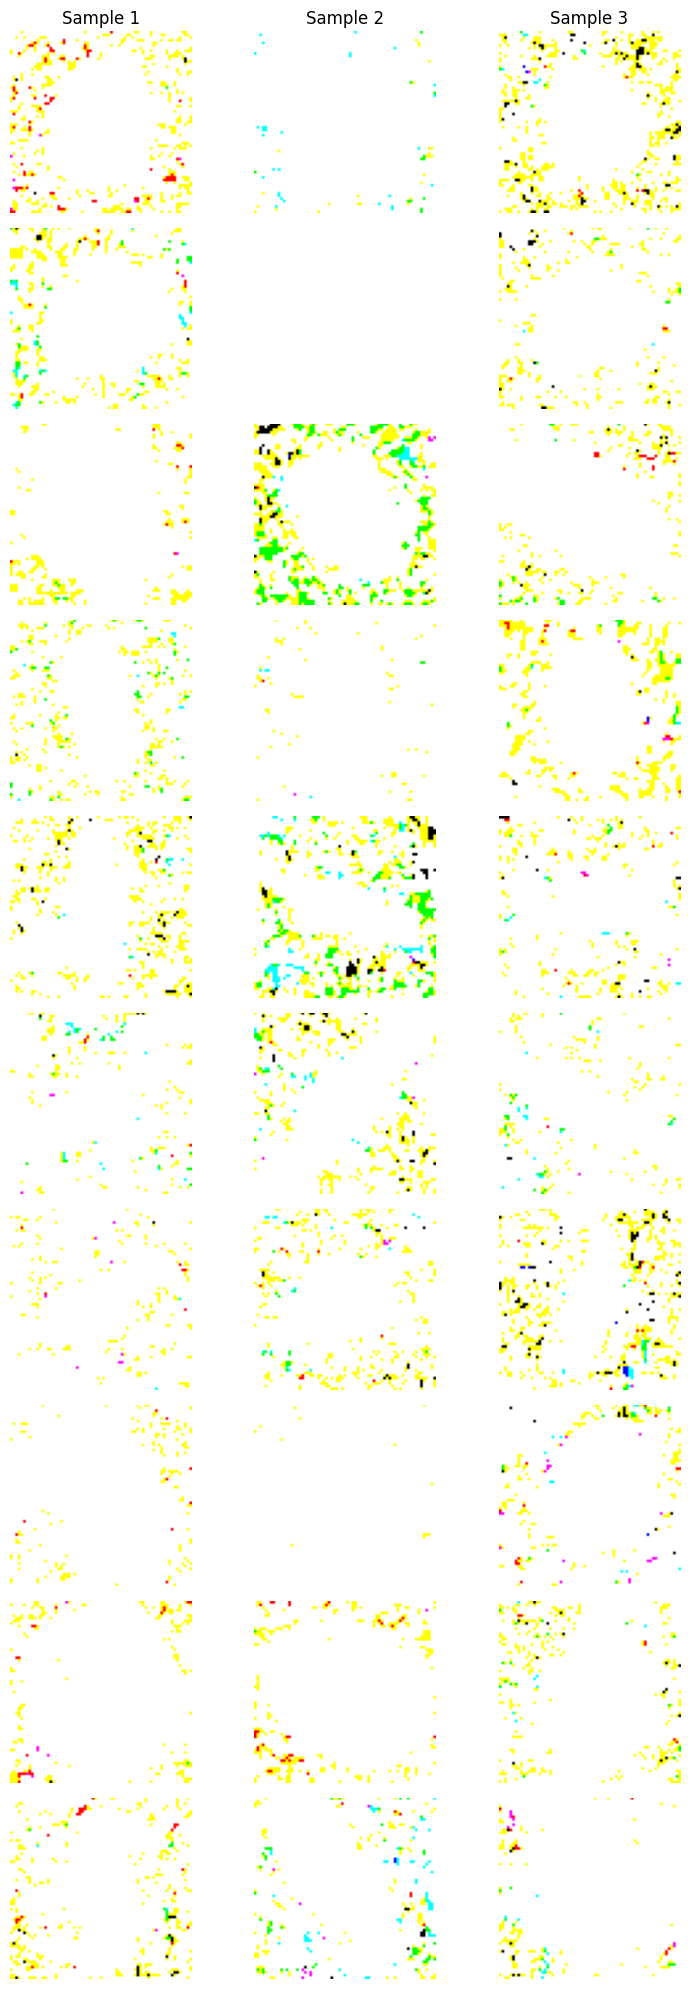

In [14]:
# Plot three samples of each class
fig, axes = plt.subplots(n_classes, 3, figsize=(8, 20))

for class_idx in range(n_classes):
    # Find indices of this class
    class_indices = torch.where(labels == class_idx)[0]
    
    # Select first 3 samples
    for sample_idx in range(3):
        ax = axes[class_idx, sample_idx]
        img = images[class_indices[sample_idx]]
        
        # Convert from (C, H, W) to (H, W, C) for plotting
        img_plot = np.moveaxis(img.numpy(), 0, -1)
        
        ax.imshow(img_plot)
        ax.axis('off')
        
        if sample_idx == 0:
            ax.set_ylabel(label_names[class_idx], fontsize=9)
        if class_idx == 0:
            ax.set_title(f'Sample {sample_idx + 1}')

plt.tight_layout()
plt.show()

In [15]:
from torchvision.transforms import Normalize

# Split the data: 80% train, 10% validation, 10% test
n_total = len(images)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

# Shuffle indices
torch.manual_seed(42)
indices = torch.randperm(n_total)

train_idx = indices[:n_train]
val_idx = indices[n_train:n_train + n_val]
test_idx = indices[n_train + n_val:]

# Split data
X_train, y_train = images[train_idx], labels[train_idx]
X_val, y_val = images[val_idx], labels[val_idx]
X_test, y_test = images[test_idx], labels[test_idx]

# Compute mean and std on training set (per channel)
mean = X_train.mean(dim=(0, 2, 3))
std = X_train.std(dim=(0, 2, 3))

print(f'Mean: {mean}, Std: {std}')
print(f'Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}')

# Normalize
normalize = Normalize(mean=mean, std=std)
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Mean: tensor([27.7031, 23.8234, 18.1529]), Std: tensor([37.5361, 31.3787, 26.3356])
Train: 17428, Val: 2178, Test: 2179


### (b)

In [16]:
# Implement a small CNN as specified on the sheet
from torch import nn

class GalaxyCNN(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        # Convolutional layers
        # Input: (batch, 3, 69, 69)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # -> (batch, 32, 69, 69)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # -> (batch, 64, 69, 69)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # -> (batch, 128, 69, 69)
        
        # Pooling
        self.pool = nn.MaxPool2d(2, 2)  # Reduces spatial dimensions by 2
        
        # After 3 pooling operations: 69 -> 34 -> 17 -> 8
        # Final feature map size: 128 * 8 * 8 = 8192
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, n_classes)
        
        # Activation
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Conv block 1
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        
        # Conv block 2
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        
        # Conv block 3
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

### 

### (c)

In [17]:
# Instantiate the model, optimizer and criterion
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = GalaxyCNN(n_classes=n_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

Using device: cpu
Model parameters: 2,193,226


### (d)

In [18]:
train_losses = []
val_losses = []
val_accs = []

def validate(model):
    model.eval()
    losses = []
    correct = []
    
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            losses.append(loss.item())
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct.append((predicted == batch_y).float().mean().item())
    
    avg_loss = np.mean(np.array(losses))
    accuracy = np.mean(np.array(correct))
    print(f'Val: accuracy={accuracy:.4f}, avg_loss={avg_loss:.4e}')
    return avg_loss, accuracy

# Initial validation
val_loss, val_acc = validate(model)
val_losses.append(val_loss)
val_accs.append(val_acc)

# Training loop
n_epochs = 30

for epoch in range(n_epochs):
    model.train()
    epoch_losses = []
    
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    # Record training loss
    avg_train_loss = np.mean(epoch_losses)
    train_losses.append(avg_train_loss)
    
    # Validate
    print(f'Epoch {epoch + 1}/{n_epochs}: Train loss={avg_train_loss:.4e}')
    val_loss, val_acc = validate(model)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

# Plot loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(range(len(train_losses)), train_losses, label='Train Loss', marker='o', markersize=3)
ax1.plot(range(len(val_losses)), val_losses, label='Val Loss', marker='s', markersize=3)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(range(len(val_accs)), val_accs, label='Val Accuracy', marker='s', markersize=3, color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\nFinal validation accuracy: {val_accs[-1]:.4f}')

Val: accuracy=0.0607, avg_loss=2.3062e+00
Epoch 1/30: Train loss=1.2975e+00
Val: accuracy=0.6147, avg_loss=9.7764e-01
Epoch 2/30: Train loss=9.2733e-01
Val: accuracy=0.7058, avg_loss=8.3240e-01
Epoch 3/30: Train loss=7.6845e-01
Val: accuracy=0.7277, avg_loss=7.0791e-01
Epoch 4/30: Train loss=6.6427e-01
Val: accuracy=0.7603, avg_loss=6.3611e-01
Epoch 5/30: Train loss=5.8582e-01
Val: accuracy=0.8054, avg_loss=5.8299e-01
Epoch 6/30: Train loss=5.3005e-01
Val: accuracy=0.7871, avg_loss=6.0591e-01
Epoch 7/30: Train loss=4.6745e-01
Val: accuracy=0.7795, avg_loss=6.2871e-01
Epoch 8/30: Train loss=4.2650e-01
Val: accuracy=0.7933, avg_loss=6.3538e-01
Epoch 9/30: Train loss=3.7198e-01
Val: accuracy=0.7835, avg_loss=6.8496e-01
Epoch 10/30: Train loss=3.5279e-01
Val: accuracy=0.7732, avg_loss=7.5283e-01
Epoch 11/30: Train loss=3.1822e-01
Val: accuracy=0.7848, avg_loss=6.9630e-01
Epoch 12/30: Train loss=2.8234e-01
Val: accuracy=0.7786, avg_loss=7.8751e-01
Epoch 13/30: Train loss=2.4967e-01
Val: acc

KeyboardInterrupt: 

### (e)

In [ ]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
            xticklabels=[name[:20] for name in label_names],
            yticklabels=[name[:20] for name in label_names])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix on Test Set')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate test accuracy
test_accuracy = (all_preds == all_labels).mean()
print(f'Test accuracy: {test_accuracy:.4f}')

### (f)

In [ ]:
# Plot the convolutional kernels of the first CNN layer
# Extract the weights from the first convolutional layer
first_conv_weights = model.conv1.weight.data.cpu()

# first_conv_weights shape: (32, 3, 3, 3) - 32 filters, 3 input channels, 3x3 kernel
n_filters = first_conv_weights.shape[0]
n_channels = first_conv_weights.shape[1]

fig, axes = plt.subplots(n_filters, n_channels, figsize=(8, 30))

for i in range(n_filters):
    for j in range(n_channels):
        ax = axes[i, j]
        kernel = first_conv_weights[i, j].numpy()
        
        # Normalize for visualization
        vmin, vmax = kernel.min(), kernel.max()
        ax.imshow(kernel, cmap='gray', vmin=vmin, vmax=vmax)
        ax.axis('off')
        
        if j == 0:
            ax.set_ylabel(f'Filter {i+1}', fontsize=8)
        if i == 0:
            ax.set_title(f'Ch {j}', fontsize=8)

plt.suptitle('Convolutional Kernels of First Layer (32 filters × 3 channels)', y=0.995)
plt.tight_layout()
plt.show()